In [1]:
import pandas as pd
import numpy as np

import sys
import glob
import os

import datetime
import time
import gc
import math
import random
from random import shuffle, randrange

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
import tensorflow as tf

# Suppress FutureWarnings from TensorFlow and other libraries
warnings.simplefilter(action='ignore', category=FutureWarning)

# Print TensorFlow version for reference
print("TensorFlow version:", tf.__version__)

# Suppress TensorFlow's verbose C++ backend logs to minimize console output clutter
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '2' suppresses INFO and WARNING messages, '3' suppresses INFO, WARNING, and ERROR messages

# Check and print available devices to confirm TensorFlow can access the CPU
print("Available devices:")
print(tf.config.list_physical_devices())

TensorFlow version: 2.16.1
Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
file_directory = ('/Users/danielabutu/Desktop/HDD journals/data_Q1_2023') #This is the directory to save our model
df_train = pd.read_csv('ST4000DM000_train.csv') #training data
df_test = pd.read_csv('ST4000DM000_test.csv') #testing data

In [4]:
df_train

,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,...,smart_9_normalized,smart_183_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized
0,2020-01-01,Z305B2QN,ST4000DM000,4000787030016,0,162984112.0,17.0,0.0,869485270.0,35462.0,...,60.0,100.0,100.0,100.0,100.0,78.0,83.0,22.0,100.0,100.0
1,2020-01-01,Z305DEMG,ST4000DM000,4000787030016,0,68281384.0,4.0,0.0,577208070.0,33765.0,...,62.0,100.0,100.0,100.0,100.0,75.0,74.0,25.0,100.0,100.0
2,2020-01-01,Z306WYZZ,ST4000DM000,4000787030016,0,214793864.0,7.0,0.0,476503651.0,20749.0,...,77.0,100.0,100.0,100.0,100.0,78.0,100.0,22.0,100.0,100.0
3,2020-01-01,Z3026Z8H,ST4000DM000,4000787030016,0,241921840.0,6.0,0.0,242883316.0,42936.0,...,51.0,100.0,100.0,100.0,100.0,80.0,73.0,20.0,100.0,100.0
4,2020-01-01,S300ZP5B,ST4000DM000,4000787030016,0,29323232.0,9.0,0.0,112689129.0,39451.0,...,55.0,100.0,100.0,100.0,100.0,82.0,81.0,18.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237058,2020-09-30,Z305JSBJ,ST4000DM000,4000787030016,0,177746488.0,6.0,0.0,86706541.0,39838.0,...,55.0,98.0,100.0,100.0,100.0,76.0,98.0,24.0,100.0,100.0
5237059,2020-09-30,S301138H,ST4000DM000,4000787030016,0,65045096.0,10.0,0.0,855756830.0,47808.0,...,46.0,100.0,100.0,100.0,100.0,81.0,84.0,19.0,100.0,100.0
5237060,2020-09-30,S300XLFH,ST4000DM000,4000787030016,0,30016160.0,13.0,0.0,631720734.0,46011.0,...,48.0,100.0,100.0,100.0,100.0,73.0,79.0,27.0,100.0,100.0
5237061,2020-09-30,Z303KECQ,ST4000DM000,4000787030016,0,136043648.0,6.0,0.0,894848450.0,33745.0,...,62.0,100.0,100.0,98.0,100.0,78.0,100.0,22.0,100.0,100.0


In [5]:
print(df_train.shape)
print(df_test.shape)

(5237063, 39)
(1746025, 39)


In [6]:
print(df_train.model.value_counts())

model
ST4000DM000    5237063
Name: count, dtype: int64


In [7]:
#checking the amount of failed disk in our training data
df_train.failure.value_counts()

failure
0    5236877
1        186
Name: count, dtype: int64

In [8]:
#checking the amount of failed disk in our testing data
df_test.failure.value_counts()

failure
0    1745942
1         83
Name: count, dtype: int64

The data is highly imbalance as theres more good HDD than failied so we try to balance it later in our analysis

## Removing the normalised column and Features that is not valid for our model

In [9]:
def prepare_dataframe(df):
    print("Removing unnecessary columns")
    
    # find and drop all normalized columns
    cols = [c for c in df.columns if (c.lower().find("normalized")!=-1)]
    df=df.drop(columns=cols)

    # also drop the model and capacity columns as we don't need them
    df = df.drop(columns=['model','capacity_bytes'])

    # convert string dates to datetime format
    df['date'] = pd.to_datetime(df['date'])

    # sort data by serial number and dates so ready for sequence creation
    print("Sorting the data frame based on serial number and date")
    df = df.sort_values(by=['serial_number', 'date'], axis=0, ascending=True)
    df = df.reset_index(drop=True)
    
    # ensure no NaN's in data
    df = df.fillna(0)
    
    return df

In [10]:
print("Processing train set...")
df_train = prepare_dataframe(df_train)

print("")
print("Processing test set...")
df_test = prepare_dataframe(df_test)

Processing train set...
Removing unnecessary columns
Sorting the data frame based on serial number and date

Processing test set...
Removing unnecessary columns
Sorting the data frame based on serial number and date


In [11]:
#checking if the columns has already been removed from our training data
df_train.shape

(5237063, 23)

In [12]:
#checking if the columns has already been removed from our test data
df_test.shape

(1746025, 23)

# Create sequences from data sets

In [13]:
# Function/routine to return serial numbers of good and bad disks 
# we will use this function later in our analysis

def get_disk_serials(df, num_disks):
    # Get failed serial numbers
    failed_serials = df[df['failure'] == 1]['serial_number'].unique().tolist()

    # Get serial numbers for disks that didn't fail - first remove failed disks
    df_tmp = df[~df.serial_number.isin(failed_serials)]
    normal_serials = df_tmp.serial_number.value_counts()[:num_disks].index.tolist()

    print('Normal Disk Serials:',len(normal_serials))
    print('Failed Disk Serials:',len(failed_serials))

    return normal_serials, failed_serials

# Adjusting the dates to have consistency in our data i.e Date Gaps

In [14]:
def adjust_dates(df_loc): 
    df_mod = pd.DataFrame(columns=df_loc.columns)
    cur_serial = df_loc['serial_number'].unique()[0]
    col_list = df_loc.columns.tolist()
    cur_dates = df_loc['date'].values
    
    # Determine the number of days between the last and first record
    num_date_range = int((cur_dates[-1] - cur_dates[0]) / np.timedelta64(1, 'D')) + 1
    
    if num_date_range > len(cur_dates):
        i_low = 0
        for i in range(len(cur_dates) - 1):
            diff_days = int((cur_dates[i+1] - cur_dates[i]) / np.timedelta64(1, 'D'))
            if diff_days > 1:
                # Use concat instead of append
                df_mod = pd.concat([df_mod, df_loc.iloc[i_low:i+1]], ignore_index=True)
                tmp_dates = [cur_dates[i] + np.timedelta64(x, 'D') for x in range(1, diff_days)]
                tmp_array = np.empty((len(tmp_dates), len(col_list)))
                tmp_array[:] = np.nan
                df_add = pd.DataFrame(tmp_array, columns=col_list)
                df_add['date'] = tmp_dates
                df_mod = pd.concat([df_mod, df_add], ignore_index=True)
                i_low = i + 1
        df_mod = pd.concat([df_mod, df_loc.iloc[i_low:]], ignore_index=True)
        df_mod = df_mod.fillna(method="ffill")
    else:
        df_mod = df_loc.copy()
    
    return df_mod


This routine fills in missing data to ensure we have consistent sequences.

In [15]:
def fix_date_gaps(df, normal_serials=None, failed_serials=None):
    df_list = []  # Create an empty list to store DataFrames

    serials_list = normal_serials + failed_serials
    for cur_serial in serials_list:
        adjusted_df = adjust_dates(df[df['serial_number'] == cur_serial])
        df_list.append(adjusted_df)  # Append the adjusted DataFrame to the list

    df_fixed = pd.concat(df_list, ignore_index=True)  # Concatenate all DataFrames in the list

    return df_fixed

# This routine builds failed sequences by finding the failure and then going back "lookahead" days and building a sequence based on the previous "sequence_length" days.

In [16]:
def create_normal_sequences(df, sequence_length, num_normal, lookahead, day_step=1):
    normal_seq_list = []
    num_seq = 0
    
    # Ensure no failed sequences in the entire dataset
    if df[df['failure'] == 1].index.size > 0: 
        return pd.DataFrame(columns=df.columns)  # Return an empty DataFrame with the same structure
    
    # Get list of normal serial numbers
    normal_serials = df.serial_number.unique().tolist()
    
    print("Number of normal serials:", len(normal_serials)) 
    
    for serial in normal_serials:
        df_tmp = df[df['serial_number'] == serial]
        num_recs = df_tmp.shape[0]
        
        for i in range(0, num_recs - (sequence_length + lookahead) + 1, day_step):
            if num_seq < num_normal:
                normal_seq_list.append(df_tmp.iloc[i:i+sequence_length])
                num_seq += 1
            else:
                break  # Stop creating sequences once the desired number is reached
    
    print("Number of normal sequences:", len(normal_seq_list))
    
    if normal_seq_list:  # Check if the list is not empty
        return pd.concat(normal_seq_list, ignore_index=True)
    else:
        return pd.DataFrame(columns=df.columns)  # Return an empty DataFrame with the same structure if no sequences are found



In [17]:
def create_failed_sequences(df, sequence_length, lookahead):
    failed_serials = df.serial_number.unique().tolist()
    print("Number of failed serials:", len(failed_serials))

    failed_seq_list = []
    for serial in failed_serials:
        df_tmp = df[df['serial_number'] == serial].reset_index(drop=True)
        num_recs = df_tmp.index.size

        if num_recs > (sequence_length + lookahead):
            df_failed = df_tmp[df_tmp['failure'] == 1]

            if not df_failed.empty:  # Ensure there is at least one failure record
                idx2 = df_failed.index[0] - lookahead + 1
                idx1 = idx2 - sequence_length

                if idx1 >= 0:  # Corrected to include sequences starting at index 0
                    failed_seq_list.append(df_tmp.iloc[idx1:idx2, :])

    print("Number of failed sequences:", len(failed_seq_list))

    if failed_seq_list:  # Check if the list is not empty
        return pd.concat(failed_seq_list, ignore_index=True)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if there are no sequences


This function will add a sequence_label column

In [18]:
# Routine to add column "sequence_label" indicating whether this was a normal or failed sequence.
# We will use this later for as label for training.
def label_sequence(df, label):
    df.insert(2, 'sequence_label', np.full(df.shape[0], label), True)
    return

## This is the parameter to fine tune

In [19]:
# Specify key parameters - you can change and re-run to test different configurations
sequence_length = 20         # Number of days in sequence to train to detect and predict failure
lookahead_days = 15           # Number of days in future to predict failure
num_normal_disks = 20        # Maximum number of normal disks to look at
max_normal_sequences = 2000  # Maximum number of normal sequences to create

Lets get serials for good and bad disk from the functions created earlier
# First we do for the training data and later for the test data

In [20]:
# get pools of serial numbers for good and bad disks
print("Determining good and bad disk serial numbers")
normal_serials, bad_serials = get_disk_serials(df_train, num_normal_disks)

df_selected = df_train[df_train.serial_number.isin(normal_serials + bad_serials)]
print('Total Records before fixing date gaps :', df_selected.shape)

df_selected = fix_date_gaps(df_selected, normal_serials, bad_serials)
print('Total Records after fixing date gaps  :', df_selected.shape)
    
# get sequences
print("Creating sequences for normal disks")
normal_sequences = create_normal_sequences(df_selected[df_selected.serial_number.isin(normal_serials)], 
                                           sequence_length, max_normal_sequences, lookahead_days)

# add field to indicate normal sequence
label_sequence(normal_sequences, 0)

print("Creating sequences for failed disks")
failure_sequences = create_failed_sequences(df_selected[df_selected.serial_number.isin(bad_serials)],
                                            sequence_length, lookahead_days)

# add field to indicate failing sequence
label_sequence(failure_sequences, 1)

# combine to creating training set
train_samples = pd.concat([normal_sequences, failure_sequences]).reset_index(drop=True)

Determining good and bad disk serial numbers
Normal Disk Serials: 20
Failed Disk Serials: 186
Total Records before fixing date gaps : (30304, 23)
Total Records after fixing date gaps  : (30310, 23)
Creating sequences for normal disks
Number of normal serials: 20
Number of normal sequences: 2000
Creating sequences for failed disks
Number of failed serials: 186
Number of failed sequences: 148


In [21]:
normal_sequences.head(2*sequence_length)

,date,serial_number,sequence_label,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2020-01-01,S3001HBH,0,0,127875696.0,20.0,0.0,109567106.0,37513.0,20.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37407.0,5.753963e+10,1.974962e+11
1,2020-01-02,S3001HBH,0,0,44311656.0,20.0,0.0,111905502.0,37537.0,20.0,...,29.0,1.0,11570.0,29.0,0.0,0.0,0.0,37431.0,5.755246e+10,1.978543e+11
2,2020-01-03,S3001HBH,0,0,189882904.0,20.0,0.0,113965453.0,37561.0,20.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37455.0,5.756602e+10,1.981536e+11
3,2020-01-04,S3001HBH,0,0,120698408.0,20.0,0.0,115961345.0,37585.0,20.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37479.0,5.758151e+10,1.982960e+11
4,2020-01-05,S3001HBH,0,0,138752016.0,20.0,0.0,117470633.0,37609.0,20.0,...,27.0,1.0,11570.0,27.0,0.0,0.0,0.0,37503.0,5.759653e+10,1.985363e+11
5,2020-01-06,S3001HBH,0,0,13338336.0,20.0,0.0,119279190.0,37632.0,20.0,...,26.0,1.0,11570.0,26.0,0.0,0.0,0.0,37527.0,5.761219e+10,1.987916e+11
6,2020-01-07,S3001HBH,0,0,146843288.0,20.0,0.0,120900842.0,37656.0,20.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37551.0,5.763734e+10,1.990414e+11
7,2020-01-08,S3001HBH,0,0,224819632.0,20.0,0.0,123986583.0,37680.0,20.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37574.0,5.765168e+10,1.993446e+11
8,2020-01-09,S3001HBH,0,0,104612584.0,20.0,0.0,125312764.0,37704.0,20.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37598.0,5.767451e+10,1.996052e+11
9,2020-01-10,S3001HBH,0,0,162077432.0,20.0,0.0,126441827.0,37728.0,20.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37622.0,5.769022e+10,1.997399e+11


In [22]:
print('We will see the First Failure Sequence')
failure_sequences.head(sequence_length)

We will see the First Failure Sequence


,date,serial_number,sequence_label,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2020-04-10,S300VLG3,1,0,69508096.0,20.0,0.0,1.005083e+12,41488.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41302.0,6.261994e+10,1.346308e+11
1,2020-04-11,S300VLG3,1,0,207025656.0,20.0,0.0,1.009380e+12,41512.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41326.0,6.263337e+10,1.346715e+11
2,2020-04-12,S300VLG3,1,0,65927848.0,20.0,0.0,1.035151e+12,41536.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41350.0,6.264974e+10,1.347084e+11
3,2020-04-13,S300VLG3,1,0,119728080.0,20.0,0.0,1.048036e+12,41564.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41378.0,6.265905e+10,1.347360e+11
4,2020-04-14,S300VLG3,1,0,79339864.0,20.0,0.0,1.060922e+12,41588.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41403.0,6.266798e+10,1.347715e+11
5,2020-04-15,S300VLG3,1,0,24464424.0,20.0,0.0,1.121053e+12,41612.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41427.0,6.268271e+10,1.348021e+11
6,2020-04-16,S300VLG3,1,0,8355704.0,20.0,0.0,1.142528e+12,41636.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41450.0,6.269805e+10,1.348241e+11
7,2020-04-17,S300VLG3,1,0,234131184.0,20.0,0.0,1.159709e+12,41660.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41475.0,6.272044e+10,1.348598e+11
8,2020-04-18,S300VLG3,1,0,208899304.0,20.0,0.0,1.176890e+12,41685.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41499.0,6.274047e+10,1.349016e+11
9,2020-04-19,S300VLG3,1,0,189616136.0,20.0,0.0,1.185481e+12,41709.0,17.0,...,25.0,2.0,36778.0,25.0,0.0,0.0,0.0,41524.0,6.276623e+10,1.349491e+11


This will show us the first failure after the lookahead days 

In [23]:
first_fail_serial = failure_sequences['serial_number'].iloc[0]
df_tmp = df_train[df_train['serial_number'] == first_fail_serial]
first_fail_index = df_tmp[df_tmp['failure'] == 1].iloc[0]

print("We should see a failure below",lookahead_days, "days after the sequence above.")
df_tmp[df_tmp['failure'] == 1].head(1)

We should see a failure below 15 days after the sequence above.


,date,serial_number,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
39315,2020-05-14,S300VLG3,1,82899576.0,20.0,64.0,1.662248e+12,42309.0,17.0,2.0,...,25.0,2.0,36778.0,25.0,32.0,32.0,0.0,42123.0,6.303354e+10,1.356903e+11


In [24]:
# check samples
num_seq = int(train_samples.shape[0] / sequence_length)
print('Training Sequences:', num_seq)

Training Sequences: 2148


In [26]:
# Store filesnames for later use
first_train_file = file_directory + 'second-LSTM_train_data_' + str(sequence_length) + '.csv'
first_test_file =  file_directory + 'second-LSTM_test_data_' + str(sequence_length) + '.csv'

# Save away training data
train_samples.to_csv(first_train_file)
del (train_samples)
gc.collect()

0

# REPEATING SAME STEP FOR THE TEST DATA

In [27]:
# get pools of serial numbers for good and bad disks
print("Determining good and bad disk serial numbers")
normal_serials, bad_serials = get_disk_serials(df_test, num_normal_disks)

dff_selected = df_test[df_test.serial_number.isin(normal_serials + bad_serials)]
print('Total Records before fixing date gaps :', dff_selected.shape)

dff_selected = fix_date_gaps(dff_selected, normal_serials, bad_serials)
print('Total Records after fixing date gaps  :', dff_selected.shape)
    
# get sequences
print("Creating sequences for normal disks")
normal_sequences = create_normal_sequences(dff_selected[dff_selected.serial_number.isin(normal_serials)], 
                                           sequence_length, max_normal_sequences, lookahead_days)

# add field to indicate normal sequence
label_sequence(normal_sequences, 0)

print("Creating sequences for failed disks")
failure_sequences = create_failed_sequences(dff_selected[dff_selected.serial_number.isin(bad_serials)],
                                            sequence_length, lookahead_days)

# add field to indicate failure sequence
label_sequence(failure_sequences, 1)

# combine to creating training set
test_samples = pd.concat([normal_sequences, failure_sequences]).reset_index(drop=True)

Determining good and bad disk serial numbers
Normal Disk Serials: 20
Failed Disk Serials: 83
Total Records before fixing date gaps : (5654, 23)
Total Records after fixing date gaps  : (5659, 23)
Creating sequences for normal disks
Number of normal serials: 20
Number of normal sequences: 1160
Creating sequences for failed disks
Number of failed serials: 83
Number of failed sequences: 51


In [28]:
#Check samples for the test data
num_seq_t = int(test_samples.shape[0] / sequence_length)
print('Test Sequences:', num_seq_t)

Test Sequences: 1211


In [30]:
# store away training and test samples
test_samples.to_csv(first_test_file)
del (test_samples)
gc.collect()

0

CREATING X AND Y LABELS

In [32]:
# Read datasets back in cleanly
dff_train = pd.read_csv(first_train_file)
dff_test = pd.read_csv(first_test_file)

dff_train.head(sequence_length)

,Unnamed: 0,date,serial_number,sequence_label,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,0,2020-01-01,S3001HBH,0,0,127875696.0,20.0,0.0,109567106.0,37513.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37407.0,5.753963e+10,1.974962e+11
1,1,2020-01-02,S3001HBH,0,0,44311656.0,20.0,0.0,111905502.0,37537.0,...,29.0,1.0,11570.0,29.0,0.0,0.0,0.0,37431.0,5.755246e+10,1.978543e+11
2,2,2020-01-03,S3001HBH,0,0,189882904.0,20.0,0.0,113965453.0,37561.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37455.0,5.756602e+10,1.981536e+11
3,3,2020-01-04,S3001HBH,0,0,120698408.0,20.0,0.0,115961345.0,37585.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37479.0,5.758151e+10,1.982960e+11
4,4,2020-01-05,S3001HBH,0,0,138752016.0,20.0,0.0,117470633.0,37609.0,...,27.0,1.0,11570.0,27.0,0.0,0.0,0.0,37503.0,5.759653e+10,1.985363e+11
5,5,2020-01-06,S3001HBH,0,0,13338336.0,20.0,0.0,119279190.0,37632.0,...,26.0,1.0,11570.0,26.0,0.0,0.0,0.0,37527.0,5.761219e+10,1.987916e+11
6,6,2020-01-07,S3001HBH,0,0,146843288.0,20.0,0.0,120900842.0,37656.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37551.0,5.763734e+10,1.990414e+11
7,7,2020-01-08,S3001HBH,0,0,224819632.0,20.0,0.0,123986583.0,37680.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37574.0,5.765168e+10,1.993446e+11
8,8,2020-01-09,S3001HBH,0,0,104612584.0,20.0,0.0,125312764.0,37704.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37598.0,5.767451e+10,1.996052e+11
9,9,2020-01-10,S3001HBH,0,0,162077432.0,20.0,0.0,126441827.0,37728.0,...,28.0,1.0,11570.0,28.0,0.0,0.0,0.0,37622.0,5.769022e+10,1.997399e+11


# NOTE
Out of the SMART attributes in all our columns, we will be using only 5 and drop the remaining attributes.
These 5 attributes are, smart_5_raw, smart_187_raw, smart_188_raw, smart_197_raw, smart_198_raw

In [33]:
#To check the columns in our training data. 
#Note that every model of HDD has different smart columns. so ensure you perform this task to remove the unwanted columns.
column_names = dff_train.columns

# To print the column names
print(column_names)

Index(['Unnamed: 0', 'date', 'serial_number', 'sequence_label', 'failure',
       'smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw',
       'smart_9_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw'],
      dtype='object')


In [34]:
#To check the columns in our testing data
column_names = dff_test.columns

# To print the column names
print(column_names)

Index(['Unnamed: 0', 'date', 'serial_number', 'sequence_label', 'failure',
       'smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw',
       'smart_9_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw'],
      dtype='object')


Before creating X and y labels, there are certain columns that we need to get rid of. As an example, we can safely remove the date column. While the date column values helped us creating the sequences, they cannot be used for training/inference purposes.

Also, the serial_number and failure columns will not be used.

# Create class labels
To train the model, we need to have the class labels for each sample.
Because we are following the same step for all three models we will comment out the model we won't be using because each HDD model have different SMART attributes that indicate failures e.g ST000NM0055 has 15 SMART attributes, ST12000NM0007 and ST4000DM000 has 14 different SMART attributes

In [37]:
# index data will hold disk serial numbers for relevant samples. We do not need serial numbers as training or testing features

#ST8000NM0055
# drop_columns_list = #['Unnamed: 0', 'date', 'serial_number', 'sequence_label', 'failure', 
# #        'smart_1_raw', 'smart_4_raw', 'smart_7_raw',
# #        'smart_9_raw', 'smart_12_raw',
# #        'smart_190_raw', 'smart_191_raw', 'smart_192_raw', 'smart_193_raw',
# #        'smart_194_raw', 'smart_195_raw','smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw']

# #ST12000NM0007
# drop_columns_list = ['Unnamed: 0', 'date', 'serial_number', 'sequence_label', 'failure',
#        'smart_1_raw', 'smart_4_raw', 'smart_7_raw',
#        'smart_9_raw', 'smart_12_raw', 
#        'smart_190_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 
#        'smart_195_raw', 'smart_199_raw',
#        'smart_240_raw', 'smart_241_raw', 'smart_242_raw']

 #ST4000DM000
drop_columns_list = ['Unnamed: 0', 'date','serial_number', 'failure', 'sequence_label', 'smart_12_raw',
       'smart_1_raw', 'smart_4_raw','smart_7_raw','smart_9_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw','smart_183_raw', 'smart_184_raw',
]


x_train = dff_train.drop(columns=drop_columns_list)
x_test = dff_test.drop(columns=drop_columns_list)

y_train = dff_train['sequence_label']
y_test = dff_test['sequence_label']

Previously, we removed the normalized columns and kept the raw ones. The reason behind this was that the normalized columns are generated based on much more samples from the original set and hence, do not represent the distribution accurately. In this section, we are going to normalize values in both test and train sets. We will utilize preprocessing.StandardScaler().fit() method for this purpose, but first we need to convert the Pandas DataFrame to NumPy arrays:

# Normalising our data using the standard scaler


In [38]:
from sklearn import preprocessing
import numpy as np

# X train data
x_train_scale = x_train.values.astype(np.float64)
scaler = preprocessing.StandardScaler().fit(x_train_scale)
x_train_scaled = scaler.transform(x_train_scale)

# X test data
x_test_scale = x_test.values.astype(np.float64)
x_test_scaled = scaler.transform(x_test_scale)

# Now, use 'x_train_scaled' and 'x_test_scaled' for training and testing your model


we need to reshape the array to get 3D data (num_samples, timesteps, num_features) needed to feed LSTM. But first we will balance our data set


Next we use SMOTE to balance our data set

In [39]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# If you haven't reshaped for LSTM yet, just use the scaled data directly
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

x_test_smote, y_test_smote = smote.fit_resample(x_test_scaled, y_test)

In [40]:
#reshaping our data to 3D

print("Reshaping training and test data for LSTM")

x_train_reshaped = x_train_smote.reshape(int(x_train_smote.shape[0] / sequence_length), sequence_length, x_train_smote.shape[1])
x_test_reshaped = x_test_smote.reshape(int(x_test_smote.shape[0] / sequence_length), sequence_length, x_test_smote.shape[1])

print("- Final Train Shape:   ", x_train_smote.shape)
print("- Original Train Shape:", x_train_reshaped.shape)

# Now, use 'x_train_reshaped' and 'x_test_reshaped' for LSTM model input


Reshaping training and test data for LSTM
- Final Train Shape:    (80000, 5)
- Original Train Shape: (4000, 20, 5)


Finally we create the y labels (failed or not) for both test and train sets (last column of y_train and y_test):

In [41]:
# Assuming y_train and y_test are Series or 1D arrays
y_train_reshaped = y_train_smote.values.reshape(-1, sequence_length)[:,-1]
y_test_reshaped = y_test_smote.values.reshape(-1, sequence_length)[:,-1]

MODEL DESIGN

# LSTM MODEL

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras import regularizers
import tensorflow as tf

# Updated parameters
dp_lvl = 0.4  # Increased dropout level to combat overfitting
units = 128  # Keeping the number of units as is, but consider experimenting with this
regularizer_lvl = 0.002  # Regularization level to prevent overfitting

model = Sequential()
model.add(LSTM(units, input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2]),dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  True ))
model.add(LSTM(units, dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  True ))
model.add(LSTM(units, dropout = dp_lvl,recurrent_dropout = dp_lvl, return_sequences =  False ))

In [56]:
# Dropout is a technique used to tackle Overfitting.
model.add(Dropout (0.4))
model.add(Dense(units, activation= 'relu',activity_regularizer=regularizers.l2(regularizer_lvl)))
model.add(Dense(1, activation='sigmoid',activity_regularizer=regularizers.l2(regularizer_lvl)))

In [57]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,417 (1.33 MB)

 Trainable params: 348,417 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
learning_rate = 0.001
momentum = 0.9
nesterov = True

#usimg the SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)

model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', 'mae'])

# Checkpoint
model_fn = "best_model.keras"  # Changed from .h5 to .keras
model_filepath = os.path.join(file_directory, model_fn) # saving the model in our file path

checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(patience=10, verbose=1)

callbacks_list = [es, checkpoint]


In [59]:
# fit network
history = model.fit(x_train_reshaped, y_train_reshaped, epochs=50, batch_size= 10, validation_split=0.10, verbose=1, shuffle=True, callbacks=callbacks_list)

Epoch 1/50
358/360 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7399 - loss: 0.6517 - mae: 0.4686
Epoch 1: val_accuracy improved from -inf to 0.97000, saving model to /Users/danielabutu/Desktop/HDD journals/data_Q1_2023/best_model.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7405 - loss: 0.6511 - mae: 0.4682 - val_accuracy: 0.9700 - val_loss: 0.2893 - val_mae: 0.1702
Epoch 2/50
359/360 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9269 - loss: 0.3736 - mae: 0.2306
Epoch 2: val_accuracy improved from 0.97000 to 0.99750, saving model to /Users/danielabutu/Desktop/HDD journals/data_Q1_2023/best_model.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9270 - loss: 0.3735 - mae: 0.2304 - val_accuracy: 0.9975 - val_loss: 0.2062 - val_mae: 0.0518
Epoch 3/50
359/360 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9507 - loss: 0.3012 - mae: 0.1539
Epoch 3: val_accuracy did not improve from 0.99750
360/360 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9507 - lo

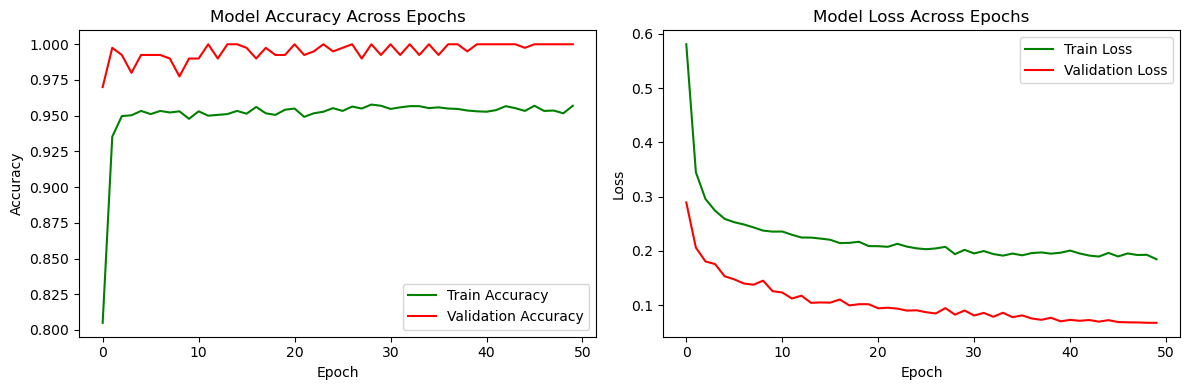

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy and loss for both training and validation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax1.plot(history.history['accuracy'], 'g', label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], 'r', label='Validation Accuracy')
ax1.set_title('Model Accuracy Across Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# Loss plot
ax2.plot(history.history['loss'], 'g', label='Train Loss')
ax2.plot(history.history['val_loss'], 'r', label='Validation Loss')
ax2.set_title('Model Loss Across Epochs')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()

Evaluate the model on the test data

In [61]:
# Compile the model with the desired loss function and metrics
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mae'])

# Evaluate the model on the test data
scores = model.evaluate(x_test_reshaped, y_test_reshaped, verbose=1)

# Print the evaluation results
print("Accuracy: %.2f%%, Mean Absolute Error: %.2f" % (scores[1]*100, scores[2]*100))

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8748 - loss: 0.5015 - mae: 0.1546
Accuracy: 91.38%, Mean Absolute Error: 10.94


In [62]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions
y_pred = model.predict(x_test_reshaped)

# For binary classification, using 0.5 as a threshold
y_pred_binary = (y_pred > 0.5).astype(int)

# Generate the classification report
print(classification_report(y_test_reshaped, y_pred_binary))

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      1160
           1       0.87      0.98      0.92      1160

    accuracy                           0.91      2320
   macro avg       0.92      0.91      0.91      2320
weighted avg       0.92      0.91      0.91      2320

